# basic analysis

In [ ]:
data_analysis['100ma'] = data_analysis['Close'].rolling(window=100,min_periods=0).mean()
# this is used to compute the average for pass 100 price (including itself)

ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1),(5,0),rowspan=5,colspan=1,sharex=ax1)
ax1.plot(data.index,data_analysis['Close'])
ax1.plot(data.index,data_analysis['100ma'])
ax2.plot(data.index,data_analysis['Total Trade Quantity'])
plt.show()

In [ ]:
data_ohlc = data_analysis['Close'].resample('10D').ohlc()
data_volume = data_analysis['Total Trade Quantity'].resample('10D').sum()
data_ohlc.reset_index(inplace=True) # the index should be 0 1 2 ....
data_ohlc['Date'] = data_ohlc['Date'].map(mdates.date2num) # transfer datetime to timestamp

ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1),(5,0),rowspan=5,colspan=1,sharex=ax1)
ax1.xaxis_date()
candlestick_ohlc(ax1,data_ohlc.values,width=2,colorup='g')
ax2.fill_between(data_volume.index.map(mdates.date2num),data_volume.values,0)
plt.show() ## candlestick graph

## calculation of Relative Strength index(RSI)

In [ ]:
TechIndicator = data.copy()

In [ ]:
# Relative Strength Index
# Avg(PriceUp)/(Avg(PriceUP)+Avg(PriceDown)*100
# Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
#        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};

def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)

In [ ]:
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)
TechIndicator['Momentum_1D'] = (TechIndicator['Close']-TechIndicator['Close'].shift(1)).fillna(0)
TechIndicator['RSI_14D'] = TechIndicator['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)
TechIndicator.tail(5)

## Calculation of Bollinger Bands

In [ ]:
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window = length, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [ ]:
TechIndicator['BB_Middle_Band'], TechIndicator['BB_Upper_Band'], TechIndicator['BB_Lower_Band'] = bbands(TechIndicator['Close'], length=20, numsd=1)
TechIndicator['BB_Middle_Band'] = TechIndicator['BB_Middle_Band'].fillna(0)
TechIndicator['BB_Upper_Band'] = TechIndicator['BB_Upper_Band'].fillna(0)
TechIndicator['BB_Lower_Band'] = TechIndicator['BB_Lower_Band'].fillna(0)
TechIndicator.tail()

## Calculation of Aroon Oscillator

In [ ]:
def aroon(df, tf=25):
    aroonup = []
    aroondown = []
    x = tf
    while x< len(df['High']):
        aroon_up = ((df['High'][x-tf:x].tolist().index(max(df['High'][x-tf:x])))/float(tf))*100
        aroon_down = ((df['Low'][x-tf:x].tolist().index(min(df['Low'][x-tf:x])))/float(tf))*100
        aroonup.append(aroon_up)
        aroondown.append(aroon_down)
        x+=1
    return aroonup, aroondown

In [ ]:
listofzeros = [0] * 25
up, down = aroon(TechIndicator)
aroon_list = [x - y for x, y in zip(up,down)]
if len(aroon_list)==0:
    aroon_list = [0] * TechIndicator.shape[0]
    TechIndicator['Aroon_Oscillator'] = aroon_list
else:
    TechIndicator['Aroon_Oscillator'] = listofzeros+aroon_list

## Calculation of Price Volume Trend
PVT = [((CurrentClose - PreviousClose) / PreviousClose) x Volume] + PreviousPVT

In [ ]:
TechIndicator["PVT"] = (TechIndicator['Momentum_1D']/ TechIndicator['Close'].shift(1))*TechIndicator['Total Trade Quantity']
TechIndicator["PVT"] = TechIndicator["PVT"]-TechIndicator["PVT"].shift(1)
TechIndicator["PVT"] = TechIndicator["PVT"].fillna(0)

## Calculation of Acceleration Bands

# 1.Prepare for dataset 

## 1.1download data from yahoo 
seperate the dataframes into several dataframes by closing price and volume

In [ ]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

tickers_list = pd.read_csv('Yahoo_Ticker_Symbols.csv')

tickers_list.drop(columns=['Category Name'],axis=1,inplace=True)

tickers = list(tickers_list.Ticker)

len(tickers)

start_time = datetime.strptime('Jan 1 2000 ', '%b %d %Y ')
start_time

for i in range(0,21):
    start = i * 5000
    end = (i+1)*5000
    Total_data_1 = pdr.get_data_yahoo(tickers=tickers[start:end],start=start_time,end=datetime.now())
    closing_price = Total_data_1['Close']
    volume = Total_data_1['Volume']
    closing_price.to_csv('closing_part'+str(i)+'.csv')
    volume.to_csv('volume_part'+str(i)+'.csv')
    print('finished '+str(i)+'loop')

## 1.2 input data as dataframe through pandas from csv files
transfer dataframe index from str to datetime to filter data on Saturday and then output as pickle file to easy input in the future analysis.

In [ ]:
import glob
import pandas as pd 
path ='data' # use your path
allFiles = glob.glob(path + "/*.csv")

clo_price_data = []
vol_data = []
for file in allFiles:
    if file.startswith('data/closing'):
        data = pd.read_csv(file).set_index('Date')
        clo_price_data.append(data)
        print('Successful import closing price file '+file)
#     else:
#         data = pd.read_csv(file).set_index('Date')
#         vol_data.append(data)
#         print('Successful import volume  file'+file)
data_clo = pd.concat(clo_price_data, axis = 1, ignore_index = False,sort=False)
data_clo.index = pd.to_datetime(data_clo.index)
# data_clo.sort_index(inplace=True)
# data_clo = data_clo.iloc[2:-1,:]

clo_price_data  = []
data_clo.index = pd.to_datetime(data_clo.index)

data_clo[data_clo.index.weekday!=6].to_pickle('data/closing_price.pkl')

## 1.3 data preprocessing 

In [12]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
clo_data = pd.read_pickle('data/closing_price.pkl')

In [3]:
clo_data.index = pd.to_datetime(clo_data.index)
clo_data.sort_index(inplace=True)  ## transfet index from str to datetime and then sort by datetime

In [4]:
clo_data.head()

,000590.KS,001040.KS,001045.KS,0038.HK,0042.HK,0107.HK,011150.KS,011155.KS,016.BE,016.SG,...,ZGL.AX,ZION,ZIONW,ZIONZ,ZIXI,ZMD.V,ZNH,ZURVY,ZZ-B.ST,ZZZ.TO
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.42703,55.5000,NaN,NaN,37.1875,NaN,7.125000,NaN,NaN,NaN
2000-01-04,10732.700195,20294.300781,57695.000000,1.10,0.44,0.55,990.0,NaN,NaN,NaN,...,0.40395,52.8125,NaN,NaN,36.5000,NaN,7.208333,NaN,NaN,NaN
2000-01-05,9920.519531,17938.699219,51069.699219,1.09,0.40,0.53,1135.0,NaN,NaN,NaN,...,0.40395,52.7500,NaN,NaN,37.2812,NaN,7.000000,NaN,NaN,NaN
2000-01-06,10210.599609,16126.700195,47895.101563,1.06,0.37,0.51,1195.0,NaN,NaN,NaN,...,0.40395,53.5000,NaN,NaN,35.2500,NaN,7.166667,NaN,NaN,NaN
2000-01-07,9427.389648,16126.700195,46928.898438,1.13,0.41,0.54,1030.0,NaN,NaN,NaN,...,NaN,53.6250,NaN,NaN,38.0000,NaN,7.250000,NaN,NaN,NaN


In [7]:
numNAs = (clo_data.isna().sum()/len(clo_data)).copy()

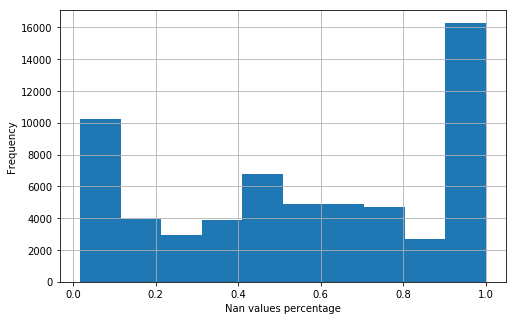

In [9]:

fig,ax = plt.subplots(figsize=(8,5))
numNAs.hist()
ax.set_xlabel('Nan values percentage')
ax.set_ylabel('Frequency')
fig.savefig('figure/Nan_value_distribution.jpg')

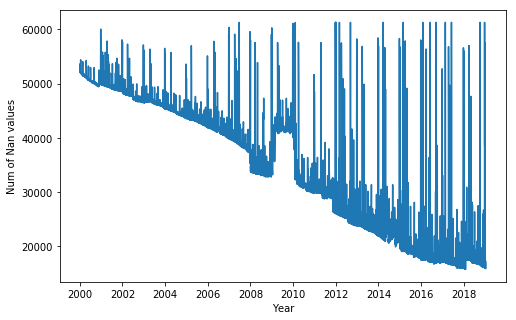

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
clearn_numNAs = clo_data.isna().sum(axis=1)
plt.plot(clearn_numNAs)
ax.set_xlabel('Year')
ax.set_ylabel('Num of Nan values')
fig.savefig('figure/Nan_value_distribution2.jpg')

In [ ]:
import missingno as msno
msno.bar(clo_data)

### select stocks which have at most 3% data missing 

In [18]:
stock_list =(numNAs<=0.03).copy()
stock_list = stock_list[stock_list==True]
cleaned_clo_data = clo_data[list(stock_list.index)]
# we select stock with nan value percentage less then 3%
# large threshold will lead to a not precision result and too low may cause too less stocks

cleaned_clo_data

,CICN.SW,CIN.L,CIR.MI,CKN.L,CLE.MI,CLEBI.IS,CLI.L,CMC.MC,CMENT.IS,CMH.L,...,SAB.MC,SAN.MC,SAND.ST,SIP.BR,SIPH.PA,SKA-B.ST,SOLV.BR,TESB.BR,UCB.BR,VBG-B.ST
2000-01-03,NaN,2384.379883,2.425,93.5,41.136902,NaN,13.55,48.066700,NaN,202.5,...,2.78284,10.27760,55.200001,NaN,NaN,79.500000,NaN,NaN,NaN,23.900600
2000-01-04,280.500000,2452.500000,2.335,93.5,39.568501,NaN,13.55,47.333302,NaN,202.5,...,2.78284,10.03370,54.200001,9.075850,NaN,76.875000,76.079300,45.554298,41.000000,23.121201
2000-01-05,270.000000,2222.399902,2.185,87.5,37.306000,NaN,13.45,45.799999,NaN,202.5,...,2.78284,9.78990,54.200001,9.114850,NaN,307.500000,70.844902,45.084599,39.779999,33.375000
2000-01-06,279.000000,2222.399902,2.150,87.5,33.835098,NaN,13.25,45.799999,NaN,202.5,...,2.78284,9.78990,54.200001,9.163590,NaN,307.500000,72.198601,45.695202,38.650002,33.375000
2000-01-07,280.000000,2222.399902,2.200,87.5,37.203201,NaN,13.25,46.333302,NaN,202.5,...,2.78284,10.22340,58.000000,9.261070,NaN,79.125000,73.101097,49.593102,39.849998,23.121201
2000-01-10,285.000000,2251.639893,2.200,87.5,39.979900,NaN,13.25,46.200001,NaN,202.5,...,2.76779,10.13310,58.000000,9.261070,NaN,79.875000,73.552299,51.612499,42.200001,23.554199
2000-01-11,280.000000,2462.229980,2.380,87.5,42.293900,NaN,13.25,45.266701,NaN,202.5,...,2.76779,9.78990,56.500000,9.261070,NaN,78.750000,73.552299,51.612499,42.200001,23.554199
2000-01-12,285.000000,2563.550049,2.580,87.5,41.651100,NaN,13.25,44.933300,NaN,202.5,...,2.76779,9.69959,55.099998,9.066100,NaN,77.500000,72.649803,47.104099,40.900002,23.554199
2000-01-13,291.000000,2992.439941,2.690,87.5,40.776901,NaN,13.25,44.000000,NaN,207.5,...,2.76779,9.61830,54.799999,9.163590,3.389000,77.000000,73.101097,48.137199,40.430000,23.554199
2000-01-14,285.000000,4776.200195,2.715,87.5,40.751202,NaN,13.40,44.933300,NaN,207.5,...,2.76779,9.87118,54.200001,9.066100,3.389000,76.250000,73.101097,48.043301,40.000000,23.554199


### distribution of stocks on exchange

<BarContainer object of 17 artists>

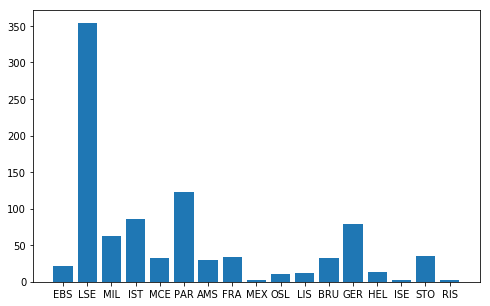

In [9]:
tickers_list = pd.read_csv('Yahoo_Ticker_Symbols.csv')

Exchange_list = tickers_list.Exchange.unique()

Ticker_df = tickers_list.set_index('Ticker')

Exchange_dict = {}
for name in cleaned_clo_data.columns:
    exchange = Ticker_df.loc[name].Exchange
    if exchange not in Exchange_dict.keys():
        Exchange_dict[exchange] = [name]
    else:
        Exchange_dict[exchange].append(name)

xdata = list(Exchange_dict.keys())
ydata = [len(Exchange_dict[key]) for key in xdata]

fig,ax = plt.subplots(figsize=(8,5))
plt.bar(xdata,ydata)

### fill nan value by ??? method 

In [19]:
price_data = cleaned_clo_data.fillna(method='ffill')

,CICN.SW,CIN.L,CIR.MI,CKN.L,CLE.MI,CLEBI.IS,CLI.L,CMC.MC,CMENT.IS,CMH.L,...,SAB.MC,SAN.MC,SAND.ST,SIP.BR,SIPH.PA,SKA-B.ST,SOLV.BR,TESB.BR,UCB.BR,VBG-B.ST
2000-01-03,NaN,2384.379883,2.425,93.5,41.136902,NaN,13.55,48.066700,NaN,202.5,...,2.78284,10.27760,55.200001,NaN,NaN,79.500000,NaN,NaN,NaN,23.900600
2000-01-04,280.500000,2452.500000,2.335,93.5,39.568501,NaN,13.55,47.333302,NaN,202.5,...,2.78284,10.03370,54.200001,9.075850,NaN,76.875000,76.079300,45.554298,41.000000,23.121201
2000-01-05,270.000000,2222.399902,2.185,87.5,37.306000,NaN,13.45,45.799999,NaN,202.5,...,2.78284,9.78990,54.200001,9.114850,NaN,307.500000,70.844902,45.084599,39.779999,33.375000
2000-01-06,279.000000,2222.399902,2.150,87.5,33.835098,NaN,13.25,45.799999,NaN,202.5,...,2.78284,9.78990,54.200001,9.163590,NaN,307.500000,72.198601,45.695202,38.650002,33.375000
2000-01-07,280.000000,2222.399902,2.200,87.5,37.203201,NaN,13.25,46.333302,NaN,202.5,...,2.78284,10.22340,58.000000,9.261070,NaN,79.125000,73.101097,49.593102,39.849998,23.121201
2000-01-10,285.000000,2251.639893,2.200,87.5,39.979900,NaN,13.25,46.200001,NaN,202.5,...,2.76779,10.13310,58.000000,9.261070,NaN,79.875000,73.552299,51.612499,42.200001,23.554199
2000-01-11,280.000000,2462.229980,2.380,87.5,42.293900,NaN,13.25,45.266701,NaN,202.5,...,2.76779,9.78990,56.500000,9.261070,NaN,78.750000,73.552299,51.612499,42.200001,23.554199
2000-01-12,285.000000,2563.550049,2.580,87.5,41.651100,NaN,13.25,44.933300,NaN,202.5,...,2.76779,9.69959,55.099998,9.066100,NaN,77.500000,72.649803,47.104099,40.900002,23.554199
2000-01-13,291.000000,2992.439941,2.690,87.5,40.776901,NaN,13.25,44.000000,NaN,207.5,...,2.76779,9.61830,54.799999,9.163590,3.389000,77.000000,73.101097,48.137199,40.430000,23.554199
2000-01-14,285.000000,4776.200195,2.715,87.5,40.751202,NaN,13.40,44.933300,NaN,207.5,...,2.76779,9.87118,54.200001,9.066100,3.389000,76.250000,73.101097,48.043301,40.000000,23.554199


In [ ]:
Closed_price = Total_data['Close']
missing_percent = Closed_price.isna().sum()/len(Closed_price)
cleaned_cloing_price = Closed_price.drop(columns=missing_percent[missing_percent>0.01].index)
cleaned_cloing_price.fillna(method='ffill',inplace=True)
cleaned_cloing_price.head()

In [ ]:
columns_list = cleaned_cloing_price.columns
Volume = Total_data['Volume']
cleaned_volume = Volume[columns_list]

In [ ]:
cleaned_volume

In [ ]:
cleaned_volume.to_csv('volume_data.csv')
cleaned_cloing_price.to_csv('cloing_data.csv')

## price return 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def log_return(row):
    r = np.log(row).diff()
    return r 

In [14]:
log_return = np.log(cleaned_clo_data).diff()

In [ ]:
plt.plot(log_return.iloc[10])

In [ ]:
cleaned_cloing_price.head()

In [ ]:
N = 100; # number of time series
T = 200  # time length
q = N/T  # ratio'

In [ ]:
price = cleaned_cloing_price.iloc[0:T+1, 0:N]
ret = np.log(price).diff()[1:]
corr_ret = np.corrcoef(ret.T)

In [ ]:
u, v = np.linalg.eig(corr_ret)

In [ ]:
lambda_plus = (1 + np.sqrt(q))**2

In [ ]:
def compute_C_minus_C0(lambdas, v, lambda_plus):
    # lambdas is a vector
    # v is an eigenvector matrix
    C_r = np.dot(np.dot(v[:,lambdas < lambda_plus], np.diag(lambdas[lambdas < lambda_plus])), v[:,lambdas < lambda_plus].T)
    C_M = lambdas.max() * np.dot(v[:, lambdas.argmax()], v[:, lambdas.argmax()].T)
    C_0 = C_r + C_M
    C = np.dot(np.dot(v, np.diag(lambdas)), v.T)
    return C - C_0

In [ ]:
import community 
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
C_s = np.abs(compute_C_minus_C0(u, v, lambda_plus))
G = nx.Graph(C_s)
part = community.best_partition(G)
values = [part.get(node) for node in G.nodes()]

nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)


In [ ]:
G = nx.Graph(C_s)
partition  = community.best_partition(G)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()